<i>Copyright (c) Microsoft Corporation.</i>

<i>Licensed under the MIT License.</i>

# Orange Juice Data Exploration in Python

In this notebook, we use Python to explore the Orange Juice (OJ) dataset. The OJ dataset is from R package [bayesm](https://cran.r-project.org/web/packages/bayesm/index.html) and is part of the [Dominick's dataset](https://www.chicagobooth.edu/research/kilts/datasets/dominicks).

## Dataset description

This dataset contains the following two tables:

- **yx.cs.** - Weekly sales of refrigerated orange juice at 83 stores. This table has 106139 rows and 19 columns. It includes weekly sales and prices of 11 orange juice
brands as well as information about profit, deal, and advertisement for each brand. Note that the weekly sales is captured by a column named `logmove` which
corresponds to the natural logarithm of the number of units sold. To get the number of units sold, you need to apply an exponential transform to this column.

- **storedemo.csv** -  Demographic information on those stores. This table has 83 rows and 13 columns. For every store, the table describes demographic information of its consumers,
distance to the nearest warehouse store, average distance to the nearest 5 supermarkets, ratio of its sales to the nearest warehouse store, and ratio of its sales
to the average of the nearest 5 stores.

Note that the week number starts from 40 in this dataset, while the full Dominick's dataset has week number from 1 to 400. According to [Dominick's Data Manual](https://www.chicagobooth.edu/-/media/enterprise/centers/kilts/datasets/dominicks-dataset/dominicks-manual-and-codebook_kiltscenter.aspx), week 1 starts on 09/14/1989.
Please see pages 40 and 41 of the [bayesm reference manual](https://cran.r-project.org/web/packages/bayesm/bayesm.pdf) and the [Dominick's Data Manual](https://www.chicagobooth.edu/-/media/enterprise/centers/kilts/datasets/dominicks-dataset/dominicks-manual-and-codebook_kiltscenter.aspx) for more details about the data.


## Global setting and imports
To run this notebook, please ensure to run through the `SETUP.md` guide in the top-level directory, which will create and activate `forecasting_env` conda environment, as well as, register that environment as a Jupyter kernel.

You can then launch the Jupyter notebook by running `jupyter notebook` and select the kernel named `forecasting_env` in the list of kernels under Kernel tab.

In [1]:
# import packages
import os
import math
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import statsmodels.api as sm

from fclib.common.utils import git_repo_path

## Dataset

Let's read in the OJ dataset and look at what it contains.

In [2]:
# Data directory
DATA_DIR = os.path.join(git_repo_path(), "ojdata")

sales_file = os.path.join(DATA_DIR, "yx.csv")
store_file = os.path.join(DATA_DIR, "storedemo.csv")

sales = pd.read_csv(sales_file, index_col=False)
storedemo = pd.read_csv(store_file, index_col=False)

In [3]:
# First few rows of sales data
sales.head(5)

,store,brand,week,logmove,constant,price1,price2,price3,price4,price5,price6,price7,price8,price9,price10,price11,deal,feat,profit
0,2,1,40,9.018695,1,0.060469,0.060497,0.042031,0.029531,0.049531,0.053021,0.038906,0.041406,0.028906,0.024844,0.038984,1,0.0,37.992326
1,2,1,46,8.723231,1,0.060469,0.060312,0.045156,0.046719,0.049531,0.047813,0.045781,0.027969,0.042969,0.042031,0.038984,0,0.0,30.126667
2,2,1,47,8.253228,1,0.060469,0.060312,0.045156,0.046719,0.037344,0.053021,0.045781,0.041406,0.048125,0.032656,0.038984,0,0.0,30.000000
3,2,1,48,8.987197,1,0.060469,0.060312,0.049844,0.037344,0.049531,0.053021,0.045781,0.041406,0.042344,0.032656,0.038984,0,0.0,29.950000
4,2,1,50,9.093357,1,0.060469,0.060312,0.043594,0.031094,0.049531,0.053021,0.046648,0.041406,0.042344,0.032656,0.038203,0,0.0,29.920000


In [4]:
# First few rows of store demographic data
storedemo.head(5)

,STORE,AGE60,EDUC,ETHNIC,INCOME,HHLARGE,WORKWOM,HVAL150,SSTRDIST,SSTRVOL,CPDIST5,CPWVOL5
0,2,0.232865,0.248935,0.114280,10.553205,0.103953,0.303585,0.463887,2.110122,1.142857,1.927280,0.376927
1,5,0.117368,0.321226,0.053875,10.922371,0.103092,0.410568,0.535883,3.801998,0.681818,1.600573,0.736307
2,8,0.252394,0.095173,0.035243,10.597010,0.131750,0.283075,0.054227,2.636333,1.500000,2.905384,0.641016
3,9,0.269119,0.222172,0.032619,10.787152,0.096830,0.358995,0.505747,1.103279,0.666667,1.820474,0.441268
4,12,0.178341,0.253413,0.380698,9.996659,0.057212,0.390942,0.386628,9.198734,1.111111,0.839303,0.105999


In [5]:
# Check number of time series and lengths
print("Number of stores is {}.".format(len(sales.groupby(["store"]).groups.keys())))
print("Number of brands is {}.".format(len(sales.groupby(["brand"]).groups.keys())))
print("Number of time series is {}.".format(len(sales.groupby(["store", "brand"]).groups.keys())))
print("\nLenth distribution of the time series:")
print(sales.groupby(["store", "brand"]).size().describe())

Number of stores is 83.
Number of brands is 11.
Number of time series is 913.

Lenth distribution of the time series:
count    913.000000
mean     116.253012
std        4.730982
min       87.000000
25%      115.000000
50%      117.000000
75%      119.000000
max      121.000000
dtype: float64


In [6]:
# Fill missing gaps
store_list = sales["store"].unique()
brand_list = sales["brand"].unique()
week_list = range(sales["week"].min(), sales["week"].max() + 1)
item_list = list(itertools.product(store_list, brand_list, week_list))
item_df = pd.DataFrame.from_records(item_list, columns=["store", "brand", "week"])

print(f"Total number of rows before filling gaps is {len(sales)}.")
sales = item_df.merge(sales, how="left", on=["store", "brand", "week"])
print(f"Total number of rows after filling gaps is {len(sales)}.")

# Fill the missing `logmove` with zeros
sales["logmove"] = sales["logmove"].fillna(value=0)

# Merge sales and store demographics
sales = sales.merge(storedemo, how="left", left_on="store", right_on="STORE")

# Compute unit sales for later analysis
sales["move"] = sales["logmove"].apply(lambda x: round(math.exp(x)) if x > 0 else 0)

Total number of rows before filling gaps is 106139.
Total number of rows after filling gaps is 110473.


## Visualize sample time series

We look at some examples of weekly sales time series for sample store and brand.

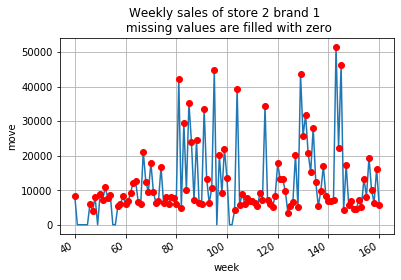

In [7]:
# Plot sample time series of sales
sample_store = 2
sample_brand = 1
sales_sub = sales.loc[(sales["store"] == sample_store) & (sales["brand"] == sample_brand)]
plt.plot(sales_sub["week"], sales_sub["move"])
plt.plot(
    sales_sub["week"].loc[sales_sub["move"] > 0],
    sales_sub["move"].loc[sales_sub["move"] > 0],
    linestyle="",
    marker="o",
    color="red",
)
plt.gcf().autofmt_xdate()
plt.xlabel("week")
plt.ylabel("move")
plt.title(f"Weekly sales of store {sample_store} brand {sample_brand} \n missing values are filled with zero")
plt.grid(True)
plt.show()

Weekly sales of all brands in store 2.


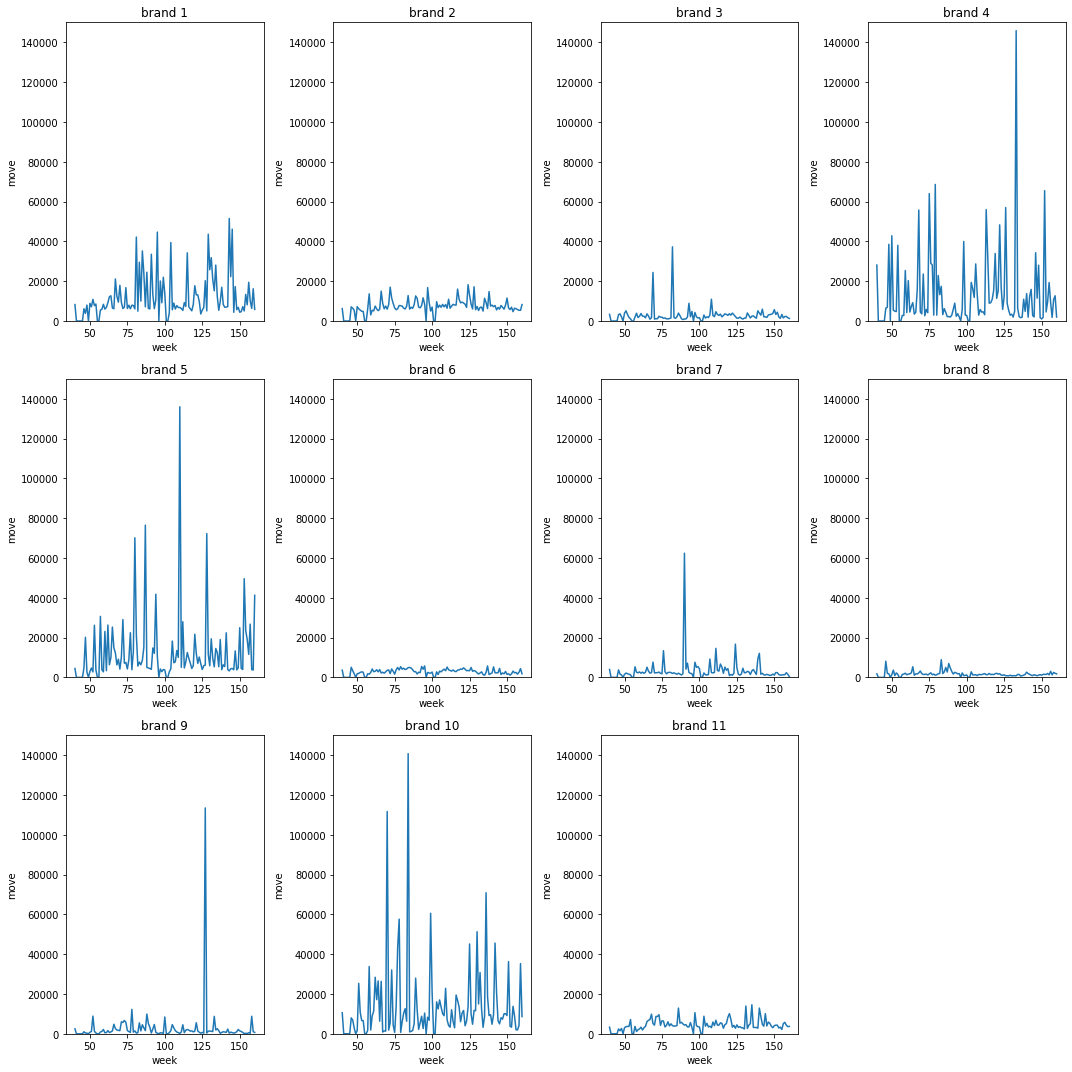

In [8]:
# Plot sales of all brands in a sample store
sample_store = 2
brand_list = sales.loc[(sales["store"] == sample_store), "brand"].unique()
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 15))
print("Weekly sales of all brands in store {}.".format(sample_store))

brand_num = 0
for row in axes:
    for col in row:
        if brand_num < len(brand_list):
            brand = brand_list[brand_num]
            sales_sub = sales.loc[(sales["store"] == sample_store) & (sales["brand"] == brand)]
            col.plot(sales_sub["week"], sales_sub["move"])
            col.set_ylim(0, 150000)
            col.set_title("brand {}".format(brand))
            col.set_xlabel("week")
            col.set_ylabel("move")
            brand_num += 1
        else:
            col.axis("off")
plt.tight_layout()

## Impact of demographics, brand, and store

In this section, we plot the boxplot of the sales across different stores, brands and different values of the demographics variables. There are variations of the sales observed across these variables. We also observed through our modeling experience that once we included the store and brand variables, the contribution of the demographic variables seems to be limited. However, submitters are encouraged to make the decision of whether to include these variables or not according their own judgement.

In [9]:
print("Correlation between unit sales and each demographic feature:")
print(sales[storedemo.columns[1:]].corrwith(sales["move"]))

print("\nCorrelation between log-scale sales and each demographic feature:")
print(sales[storedemo.columns[1:]].corrwith(sales["logmove"]))

Correlation between unit sales and each demographic feature:
AGE60       0.047409
EDUC       -0.026599
ETHNIC      0.074581
INCOME     -0.050484
HHLARGE     0.000940
WORKWOM    -0.063461
HVAL150    -0.026362
SSTRDIST    0.032859
SSTRVOL    -0.027255
CPDIST5     0.006355
CPWVOL5    -0.078144
dtype: float64

Correlation between log-scale sales and each demographic feature:
AGE60       0.034674
EDUC       -0.012200
ETHNIC      0.044293
INCOME     -0.023183
HHLARGE    -0.026629
WORKWOM    -0.023059
HVAL150    -0.002460
SSTRDIST   -0.006033
SSTRVOL    -0.071799
CPDIST5     0.026050
CPWVOL5    -0.059456
dtype: float64


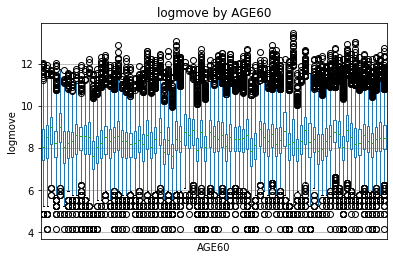

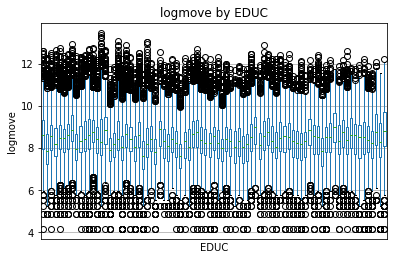

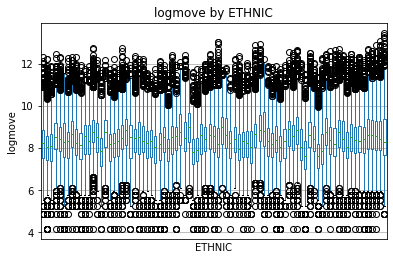

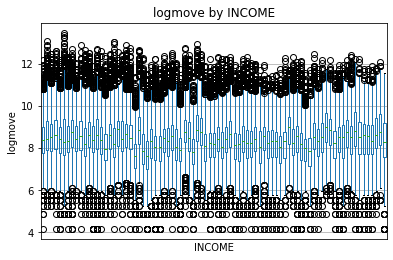

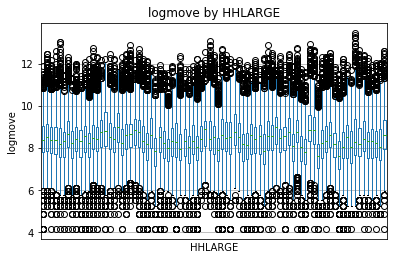

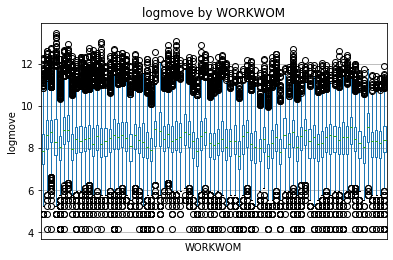

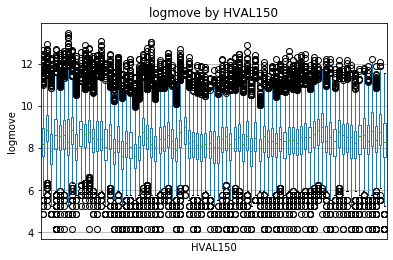

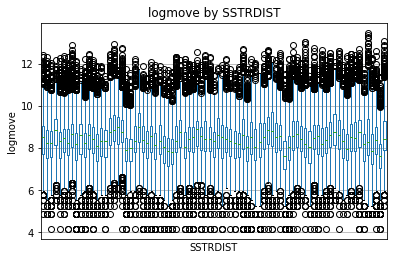

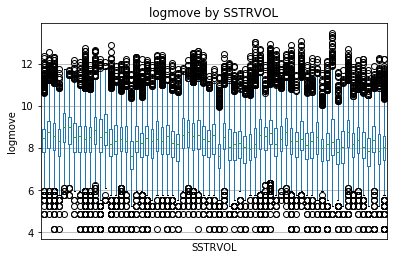

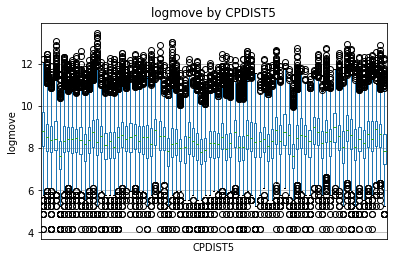

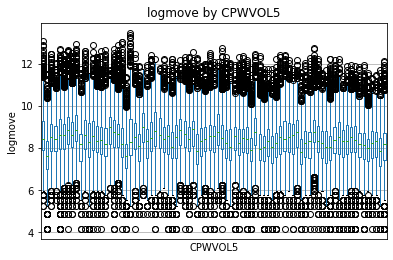

In [10]:
# Plot box plot of logmove vs. store demographic columns
for cl in storedemo.columns[1:]:
    p = sales.loc[sales["logmove"] != 0].boxplot(column="logmove", by=cl)
    p.set_title("logmove by {}".format(cl), linespacing=3)
    p.set_xlabel(cl)
    p.set_ylabel("logmove")
    p.get_xaxis().set_ticks([])
    plt.suptitle("")

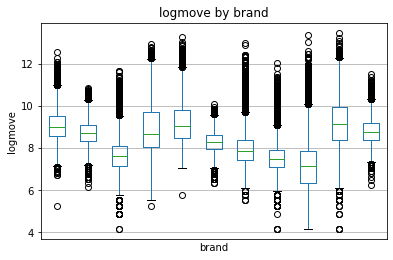

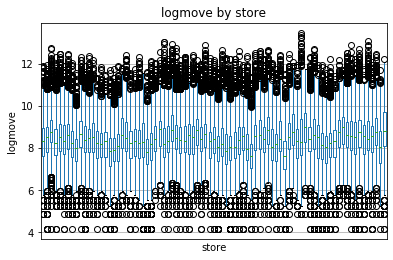

In [11]:
# Plot box plot of logmove across different brands and stores
for by_cl in ["brand", "store"]:
    p = sales.loc[sales["logmove"] != 0].boxplot(column="logmove", by=by_cl)
    p.set_title("logmove by {}".format(by_cl), linespacing=3)
    p.set_xlabel(by_cl)
    p.set_ylabel("logmove")
    p.get_xaxis().set_ticks([])
    plt.suptitle("")

## Check seasonality and autocorrelation

Overall, we don't find a strong seasonality in the data. It seems that there is a weak yearly-seasonality according to the seasonal-trend-level decomposition and the autocorrelation values around the lag of 52 weeks. As a rough estimate, autocorrelation beyond 20 weeks is usually very small.

/data/anaconda/envs/forecasting_env/lib/python3.6/site-packages/ipykernel_launcher.py:4: FutureWarning: the 'freq' keyword is deprecated, use 'period' instead
  after removing the cwd from sys.path.


Figure(432x288)


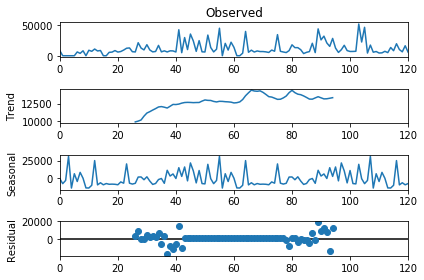

In [12]:
# Check Seasonality
# Not much seasonality is found
d = sales.loc[(sales["store"] == 2) & (sales["brand"] == 1)].copy()
decom = sm.tsa.seasonal_decompose(d["move"].values, freq=52)
print(decom.plot())

In [13]:
# autocorrealtion: weekly, monthly, quarterly, yearly
def single_autocorr(series, lag):
    """
    Autocorrelation for single data series
    :param series: traffic series
    :param lag: lag, days
    :return:
    """
    s1 = series[lag:]
    s2 = series[:-lag]
    ms1 = np.mean(s1)
    ms2 = np.mean(s2)
    ds1 = s1 - ms1
    ds2 = s2 - ms2
    divider = np.sqrt(np.sum(ds1 * ds1)) * np.sqrt(np.sum(ds2 * ds2))
    return np.sum(ds1 * ds2) / divider if divider != 0 else 0

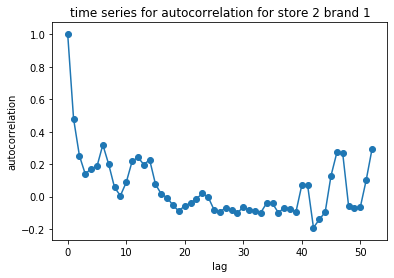

/data/anaconda/envs/forecasting_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/data/anaconda/envs/forecasting_env/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


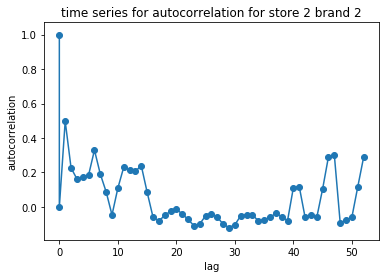

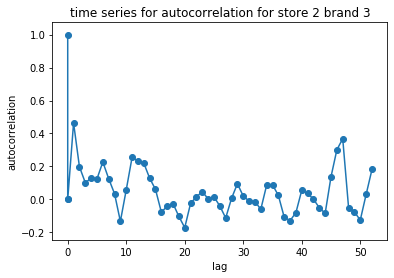

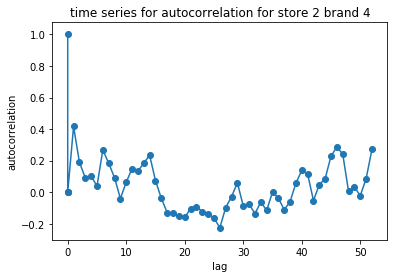

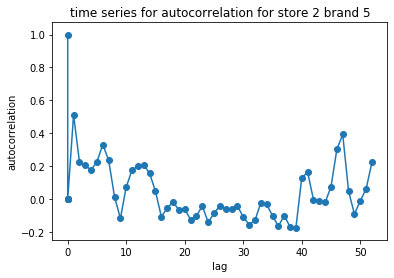

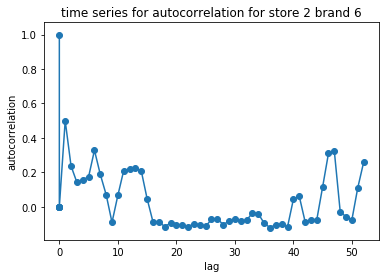

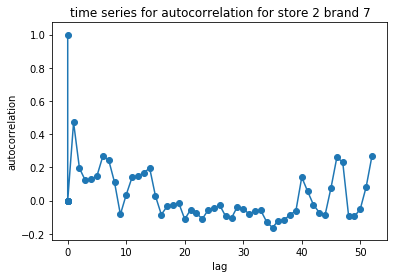

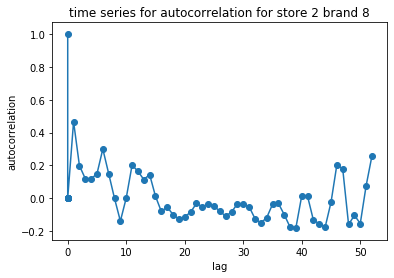

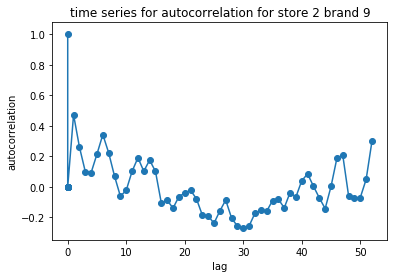

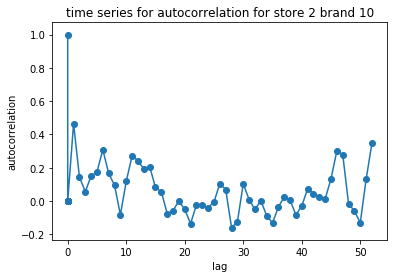

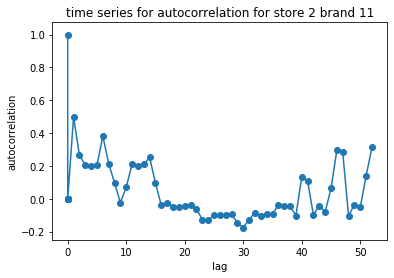

In [14]:
sample_store = 2
brand_list = sales["brand"].unique()
l_range = list(range(1, 53))

for j in range(len(brand_list)):
    brand = brand_list[j]
    d = sales.loc[(sales["store"] == sample_store) & (sales["brand"] == brand)].copy()
    cor = []
    for l in l_range:
        cor.append(single_autocorr(d["logmove"].values, l))
    l_range.insert(0, 0)
    cor.insert(0, 1)
    plt.scatter(list(l_range), cor)
    plt.plot(list(l_range), cor)
    plt.title("time series for autocorrelation for store {} brand {}".format(sample_store, brand))
    plt.xlabel("lag")
    plt.ylabel("autocorrelation")
    plt.show()

## Impact of promotional information: deal and feat

We find that deal column has a very significant impact on sales. The impact of feat column also looks strong although the pattern shown in the scatter plot is a bit noisy.

Text(0, 0.5, 'logmove')

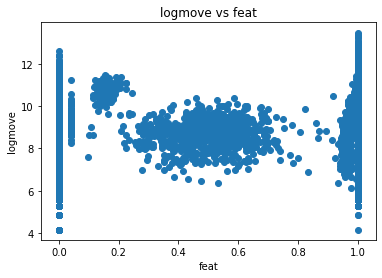

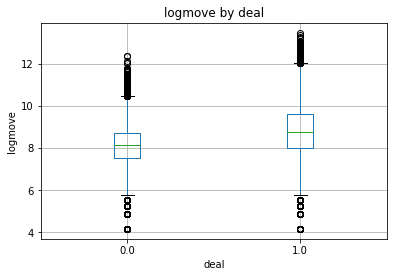

In [15]:
# Check the impact of deal, feat by plotting logmove vs feat and deal
# These two features significantly impact the sales
plt.scatter(sales["feat"], sales["logmove"])
plt.title("logmove vs feat")
plt.xlabel("feat")
plt.ylabel("logmove")
p = sales.boxplot(column="logmove", by="deal")
plt.suptitle("")
p.set_title("logmove by deal", linespacing=3)
p.set_xlabel("deal")
p.set_ylabel("logmove")

## Impact of price

We find that the sales does typically decrease when the absolute price or the relative price of the product increases.

In [16]:
# correlation between the sales and price, sales and relative price
sales["price"] = sales.apply(lambda x: x.loc["price" + str(int(x.loc["brand"]))], axis=1)
price_cols = [
    "price1",
    "price2",
    "price3",
    "price4",
    "price5",
    "price6",
    "price7",
    "price8",
    "price9",
    "price10",
    "price11",
]
sales["avg_price"] = sales[price_cols].sum(axis=1).apply(lambda x: x / len(price_cols))
sales["price_ratio"] = sales.apply(lambda x: x["price"] / x["avg_price"], axis=1)

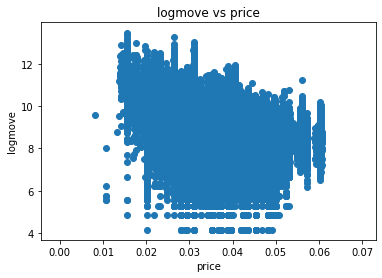

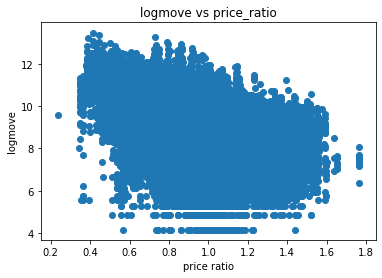

In [17]:
plt.scatter(sales["price"], sales["logmove"])
plt.title("logmove vs price")
plt.xlabel("price")
plt.ylabel("logmove")
plt.show()
plt.scatter(sales["price_ratio"], sales["logmove"])
plt.title("logmove vs price_ratio")
plt.xlabel("price ratio")
plt.ylabel("logmove")
plt.show()